# Introduction 

Natural language processing (NLP) refers to the field within artificial intelligence that deals with the interaction between computers and humans using the natural language. This includes enabling computers to manipulate, analyse, interpret and generate human language. 

This notebook is heavily inspired by [NLP with Python for Machine Learning Essential Training](https://www.linkedin.com/learning/nlp-with-python-for-machine-learning-essential-training), a course given by [Derek Jedamski](https://www.linkedin.com/in/derek-jedamski-8a887045/?trk=lil_course) on LinkedIn. My goal with this notebook is to summarise what I have learned from the course as well as recreate the results of a spam classifier, a binary classifier (prediction model) capable of classifying a given text message as *ham* or *spam*. 

The [SMS spam collection dataset](https://www.kaggle.com/uciml/sms-spam-collection-dataset) is a set of SMS tagged messages that have been collected for SMS spam research. It contains a set of 5,572 SMS messages in English, tagged according to ham (legitimate) or spam. 

For ease of reference, this notebook is structured as follows:
0. Import libraries
1. Import and read data
2. Exploratory data analysis (EDA)
3. Feature engineering
4. Cleaning text
5. Vectorization
6. Modelling (using RandomForestClassifier and GradientBoostingClassifier)

Again, I would like to give full credits and reference to [Derek Jedamski](https://www.linkedin.com/in/derek-jedamski-8a887045/?trk=lil_course) for his work and I recommend checking out his courses on LinkedIn.

Without further ado, let's begin!

# 0. Import libraries

In [ ]:
# Read files 
import os

# Data wrangling and data visualistion 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Processing texts
import nltk
import re
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

# Machine learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score

# Others
import numpy as np
from collections import Counter
import time
from statistics import mean

# 1. Import and read data

In [ ]:
# Read data 
data = pd.read_csv("../input/sms-spam-collection-dataset/spam.csv", encoding = "latin-1")
data = data.dropna(how = "any", axis = 1)
data.columns = ['label','body_text']
data.head()

# 2. Exploratory data analysis (EDA)

Exploratory data analysis is the process of performing initial investigations on data so as to discover patterns, to spot anomalies, to test hypothesis and to check assumptions with the help of summary statistics and graphical representations (definition credits to Prasad Patil on "[What is Exploratory Data Analysis?](https://towardsdatascience.com/exploratory-data-analysis-8fc1cb20fd15)").  

In [ ]:
print(f"Input data has {len(data)} rows and {len(data.columns)} columns.")

In [ ]:
print(f"Out of {len(data)} rows, {len(data[data.label == 'spam'])} are spam and {len(data[data.label == 'ham'])} are ham.")

In [ ]:
total = len(data)
plt.figure(figsize = (5, 5))
plt.title("Number of spam vs ham messages")
ax = sns.countplot(x = 'label', data = data)
for p in ax.patches:
    percentage = '{0:.0f}%'.format(p.get_height() / total * 100)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 20
    ax.annotate(percentage, (x, y), ha = 'center')
plt.show()

There are significantly more ham messages (87%) than there are spam messages (13%). 

In [ ]:
print(f"Number of null in label: {data.label.isnull().sum()}")
print(f"Number of null in text: {data.body_text.isnull().sum()}")

Yay, no missing data!

# 3. Feature engineering

Feature engineering is the process of creating new features and/or transforming existing features to get the most out of your data. 

In this section, I will create two new features:
- body_len (length of the body text excluding spaces)
- punct% (percentage of punctuation in the body text) 

There are many other features that you can create to analyse a string or sentence, here are some [ideas](https://www.analyticsvidhya.com/blog/2021/04/a-guide-to-feature-engineering-in-nlp/) to get started.

In [ ]:
# body_len
data['body_len'] = data.body_text.apply(lambda x: len(x) - x.count(" "))

# punct%
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3) * 100
data['punct%'] = data.body_text.apply(lambda x: count_punct(x))

data.head()

In [ ]:
# Summary statistics
data[['body_len', 'punct%']].describe().transpose()

Let's have a look at the text with maximum body_len as well as the text with maximum punct%.

In [ ]:
# Text with maximum body_len
list(data.loc[data.body_len == 740, 'body_text'])

In [ ]:
# Text with maximum punct%
list(data.loc[data['punct%'] == 100, 'body_text'])

Now, use the newly created features to explore the text distribution.

In [ ]:
# Plot body_len distribution for ham and spam messages 
bins = np.linspace(0, 200, 40)
data.loc[data.label == 'spam', 'body_len'].plot(kind = 'hist', bins = bins, alpha = 0.5, density = True, label = 'spam')
data.loc[data.label == 'ham', 'body_len'].plot(kind = 'hist', bins = bins, alpha = 0.5, density = True, label = 'ham')
plt.legend(loc = 'best')
plt.xlabel("body_len")
plt.title("Body length ham vs spam")
plt.show()

As we can see, spam messages have a longer body length i.e. contain more words. 

What about punctuation percentage?

In [ ]:
# Plot punct% for ham and spam messages 
bins = np.linspace(0, 50, 40)
data.loc[data.label == 'spam', 'punct%'].plot(kind = 'hist', bins = bins, alpha = 0.5, density = True, label = 'spam')
data.loc[data.label == 'ham', 'punct%'].plot(kind = 'hist', bins = bins, alpha = 0.5, density = True, label = 'ham')
plt.legend(loc = 'best')
plt.xlabel("punct%")
plt.title("Punctuation percentage ham vs spam")
plt.show()

The two distributions don't look awfully different although ham messages do appear to have a longer tail i.e. ham messages tend to have a higher punctuation percentage.

# 4. Cleaning text 

In order to better manage our messy text messages, we will perform the following steps to clean up the input data:

- Turn words into lowercase letters only 
- Remove punctuation
- Tokenize words
- Remove stopwords
- Stemming vs lemmatization (text normalization)

## 4.1 Turn words into lowercase letters only

Python does not see all characters as equal. Thus, we will need to convert all words into lowercase letters for consistency. 

In [ ]:
"NLP" == "nlp"

In [ ]:
"NLP".lower() == "nlp"

## 4.2 Remove punctuation

The rationale behind removing punctuation is that punctuation does not hold any meaning in a text. We want Python to only focus on the words in a given text and not worry about the punctuations that are involved. 

In [ ]:
"I love NLP" == "I love NLP."

As humans, we can almost immediately see that the two texts above are exactly the same. However, Python fails to realise this. It is therefore important that we remove all punctuations in order to allow Python to interpret the text more clearly. 

These are the punctuations that are stored in the **string** library in Python. 

In [ ]:
# List of punctuations in the string library 
string.punctuation

We can use [list comprehension](https://www.w3schools.com/python/python_lists_comprehension.asp) to remove all punctuations in a string of characters. 

In [ ]:
# Remove punctuation 
text = 'OMG! Did you see what happened to her? I was so shocked when I heard the news. :('
print(text)
text = "".join([word for word in text if word not in string.punctuation])
print(text)

Taadaa, all punctuations have been removed!

## 4.3 Tokenize words 

Tokenizing involves splitting a string or sentence into a list of characters and we can do so by utilising the **regular expression (re)** library in Python. 

In [ ]:
# Available commands in the re library 
dir(re)

Let's look at an example of tokenization using two different commands:
- re.split
- re.findall

In [ ]:
messy_text = 'This-is-a-made/up.string*to>>>>test----2""""""different~regex-methods'
re.split('\W+', messy_text)

In [ ]:
re.findall('\w+', messy_text)

Both commands have not only removed all punctuations but more importantly tokenized the text into a list of words. 

## 4.4 Remove stopwords

Stopwords are commonly used words in the English language like *but*, *if* and *the* that don't contribute much to the overall meaning of a sentence. For this reason, stopwords are usually removed in order to reduce the number of tokens Python needs to process when building our model. 

Stopwords are stored in **nltk.corpus.stopwords** and here are some examples.

In [ ]:
# Examples of stopwords 
stopwords = nltk.corpus.stopwords.words('english')
stopwords[0:500:25]

Let's again apply list comprehension to remove all stopwords in a given string. 

In [ ]:
print(text)
print(text.lower().split())
print([word for word in text.lower().split() if word not in stopwords])

We have successfully removed the following stopwords from the original text:
- did
- you
- what
- to
- her
- i
- was
- so
- when
- the

Notice that we first turned the original text into a list of lowercase words before running our list comprehension. This is because words are stored in lowercase letters in the nltk library. 

## 4.5 Stemming vs lemmatization (word normalization)

**Stemming:** The process of reducing inflection or derived words to their word stem or root by crudely chopping off the ends of a word to leave only the base.
**Lemmatizing:** The process of grouping together inflected forms of a word so they can be analyzed as a single term. 

Broadly speaking, both stemming and lemmatizing serve the purpose of condensing the variations of the same word down to its root form. This is to prevent the computer from storing every single unique word it sees in a corpus of words but instead only take note of a word in its most basic form and correlate other words with similar meanings. 

For example, *grew*, *grown*, *growing* and *growth* are all simply variations to the word *grow*. In this case, the computer only needs to remember the word *grow* and not the rest. 

In [ ]:
ps = nltk.PorterStemmer()
wn = nltk.WordNetLemmatizer()

In [ ]:
print(ps.stem('goose'))
print(ps.stem('geese'))

In [ ]:
print(wn.lemmatize('goose'))
print(wn.lemmatize('geese'))

As we can see, stemming takes a more crude approach than lemmatizing by simply chopping off the end of a word using heuristics, without any understanding of the context in which a word is used. As a result,stemming can sometimes not return an actual word in the dictionary unlike lemmatizing which will always return a dictionary word. 

Lemmatizing, on the other hand, considers multiple factors before simplifying a given word and is generally considered more accurate compared to stemming. However, this comes at the expense of being slower and more computationally expensive than stemming. 

## 4.6 Putting everything together into a single clean_text function 

Now, we want to summarise everything that we have learned about text cleaning into a single function that we can apply to our original text messages data. 

In [ ]:
# Create function for cleaning text  
def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.findall('\S+', text)
    # text = [ps.stem(word) for word in tokens if word not in stopwords]
    text = [wn.lemmatize(word) for word in tokens if word not in stopwords]
    return text

# Apply function to body_text 
data['cleaned_text'] = data['body_text'].apply(lambda x: clean_text(x))
data[['body_text', 'cleaned_text']].head(10)

In [ ]:
# Collect ham words
ham_words = list(data.loc[data.label == 'ham', 'cleaned_text'])

# Flatten list of lists
ham_words = list(np.concatenate(ham_words).flat)

# Create dictionary to store word frequency
ham_words = Counter(ham_words)
pd.DataFrame(ham_words.most_common(50), columns = ['word', 'frequency'])

In [ ]:
# Collect spam words
spam_words = list(data.loc[data.label == 'spam', 'cleaned_text'])

# Flatten list of lists
spam_words = list(np.concatenate(spam_words).flat)

# Create dictionary to store word frequency
spam_words = Counter(spam_words)
pd.DataFrame(spam_words.most_common(50), columns = ['word', 'frequency'])

Unfortunately, nltk did not account for all the variations to stopwords. Here, I will define some extra stopwords to further clean up our corpus of words. 
- u = you
- im = I'm
- 2 = to
- ur = your
- ill = I'll
- 4 = for
- lor (slang word)
- r = are
- n = and
- da = the
- oh (slang word) 

In [ ]:
# Define extra stopwords
extra_stopwords = ['u', 'im', '2', 'ur', 'ill', '4', 'lor', 'r', 'n', 'da', 'oh']

# Remove extra stopwords  
data['cleaned_text'] = data['cleaned_text'].apply(lambda x: [word for word in x if word not in extra_stopwords])

In [ ]:
# Organise ham words data
ham_words = list(data.loc[data.label == 'ham', 'cleaned_text'])
ham_words = list(np.concatenate(ham_words).flat)
ham_words = Counter(ham_words)
ham_words = pd.DataFrame(ham_words.most_common(30), columns = ['word', 'frequency'])

# Plot most common harm words
fig, ax = plt.subplots(figsize = (15, 5))
sns.barplot(x = 'word', y = 'frequency', data = ham_words, ax = ax)
plt.xticks(rotation = '90')
plt.title("30 most common ham words")

In [ ]:
# Organise spam words data
spam_words = list(data.loc[data.label == 'spam', 'cleaned_text'])
spam_words = list(np.concatenate(spam_words).flat)
spam_words = Counter(spam_words)
spam_words = pd.DataFrame(spam_words.most_common(30), columns = ['word', 'frequency'])

# Plot most common harm words
fig, ax = plt.subplots(figsize = (15, 5))
sns.barplot(x = 'word', y = 'frequency', data = spam_words, ax = ax)
plt.xticks(rotation = '90')
plt.title("30 most common spam words")

# 5. Vectorization 

Vectorizing is the process of encoding text as integers to create feature vectors. 

## 5.1 How (Countvectorizer + TfidfTransformer) works

[CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) creates a document-term matrix where the entry of each cell will be a count of the number of times that word occured in that document. 

[TfidfTransformer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) is similar to that of a CountVectorizer but instead of the cells representing the count, the cells represent a weighting that is meant to identify how important a word is to an individual text message. The formula to compute the weighting for each cell is as follows:
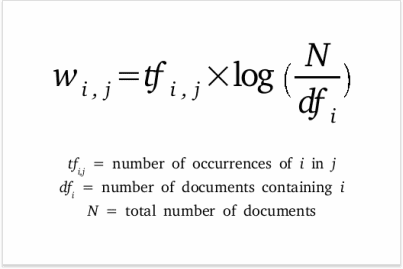

In [ ]:
# CountVectorizer
corpus = ['I love bananas', 'Bananas are so amazing!', 'Bananas go so well with pancakes']
count_vect = CountVectorizer()
corpus = count_vect.fit_transform(corpus)
count_vect.get_feature_names()

In [ ]:
pd.DataFrame(corpus.toarray(), columns = count_vect.get_feature_names())

In [ ]:
# TfidfTransformer
tfidf_transformer = TfidfTransformer()
corpus = tfidf_transformer.fit_transform(corpus)
pd.DataFrame(corpus.toarray(), columns = count_vect.get_feature_names())

## 5.2 How TfidfVectorizer works

[TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) is equivalent to CountVectorizer followed by TfidfTransformer. 

In [ ]:
# TfidfVectorizer
corpus = ['I love bananas', 'Bananas are so amazing!', 'Bananas go so well with pancakes']
tfidf_vect = TfidfVectorizer()
corpus = tfidf_vect.fit_transform(corpus)
pd.DataFrame(corpus.toarray(), columns = tfidf_vect.get_feature_names())

As we can see, we get exactly the same result as section 5.1.

Since the results are the same, we will use TfidfVectorizer in this notebook. 

# 6. Modelling

Now that our data is ready, we can finally move on to modelling, that is building a binary classifier to classify a given text as ham or spam.

Here, we will consider two approach: **train-test-split** and **pipeline** as well as two types of machine learning models, or more specifically, ensemble methods: **random forest** and **gradient boosting**.

Ensemble method is a technique that creates multiple models and then combinese them to produce better results than any of the single models individually. 

## 6.1 Train-test-split approach

In [ ]:
data.head()

In [ ]:
# Train test split
X_train, X_test, Y_train, Y_test = train_test_split(data[['body_text', 'body_len', 'punct%']], data.label, random_state = 42, test_size = 0.2)

# Check shape 
print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")

In [ ]:
# Instantiate and fit TfidfVectorizer
tfidf_vect = TfidfVectorizer(analyzer = clean_text)
tfidf_vect_fit = tfidf_vect.fit(X_train['body_text'])

# Use fitted TfidfVectorizer to transform body text in X_train and X_test
tfidf_train = tfidf_vect.transform(X_train['body_text'])
tfidf_test = tfidf_vect.transform(X_test['body_text'])

# Recombine transformed body text with body_len and punct% features
X_train = pd.concat([X_train[['body_len', 'punct%']].reset_index(drop = True), pd.DataFrame(tfidf_train.toarray())], axis = 1)
X_test = pd.concat([X_test[['body_len', 'punct%']].reset_index(drop = True), pd.DataFrame(tfidf_test.toarray())], axis = 1)

# Check shape
print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")

## 6.1.1 RandomForestClassifier

[RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) is an ensemble learning method (bagging) that constructs a collection of decision trees and then aggregates the predictions of each tree to determine the final prediction.

In [ ]:
# Default random forest 
print(RandomForestClassifier())

The key hyperparameters to pay attention to are:
- **max_depth** (maximum depth of each decision tree)
- **n_estimators** (how many parallel decision trees to build)
- **random_state** (for reproducibility purpose)
- **n_jobs** (number of jobs to run in parallel) 

Let's now manually build a simple grid search using nested for loops in order to explore the most optimal set of hyperparameters.

In [ ]:
# Manual grid search for random forest 
def explore_rf_params(n_est, depth):
    rf = RandomForestClassifier(n_estimators = n_est, max_depth = depth, n_jobs = -1, random_state = 42)
    rf_model = rf.fit(X_train, Y_train)
    Y_pred = rf_model.predict(X_test)
    precision, recall, fscore, support = score(Y_test, Y_pred, pos_label = 'spam', average = 'binary')
    print(f"Est: {n_est} / Depth: {depth} ---- Precision: {round(precision, 3)} / Recall: {round(recall, 3)} / Accuracy: {round((Y_pred==Y_test).sum() / len(Y_pred), 3)}")
    
for n_est in [50, 100, 150]:
    for depth in [10, 20, 30, None]:
        explore_rf_params(n_est, depth)

Precision is constant at 1 for all cases. Recall and accuracy, on the other hand, improves as max_depth increases with None max_depth giving the best results. There is very little additional improvement adding 50 more trees after the 100th tree so we will set n_estimators = 100.

In [ ]:
# Instantiate RandomForestClassifier with optimal set of hyperparameters 
rf = RandomForestClassifier(n_estimators = 100, max_depth = None, random_state = 42, n_jobs = -1)

# Fit model
start = time.time()
rf_model = rf.fit(X_train, Y_train)
end = time.time()
fit_time = end - start

# Predict 
start = time.time()
Y_pred = rf_model.predict(X_test)
end = time.time()
pred_time = end - start

# Time and prediction results
precision, recall, fscore, support = score(Y_test, Y_pred, pos_label = 'spam', average = 'binary')
print(f"Fit time: {round(fit_time, 3)} / Predict time: {round(pred_time, 3)}")
print(f"Precision: {round(precision, 3)} / Recall: {round(recall, 3)} / Accuracy: {round((Y_pred==Y_test).sum() / len(Y_pred), 3)}")

In [ ]:
# Confusion matrix for RandomForestClassifier
matrix = confusion_matrix(Y_test, Y_pred)
sns.heatmap(matrix, annot = True, fmt = 'd')

## 6.1.2 GradientBoostingClassifier

[GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) is an ensemble learning method (boosting) that takes an iterative approach to combining weak learners to create a strong learner by focusing on mistakes of prior iterations. 

In [ ]:
# Default gradient boosting 
print(GradientBoostingClassifier())

The key hyperparameters to pay attention to are:
- **learning_rate** (weight of each sequential tree on the final prediction)
- **max_depth** (maximum depth of each decision tree)
- **n_estimators** (number of sequential trees)
- **random_state** (for reproducibility purpose)

Unfortunately, grid search for gradient boosting will take a long time so let's just use the default hyperparameters for now.

In [ ]:
# Instantiate GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state = 42)

# Fit model
start = time.time()
gb_model = gb.fit(X_train, Y_train)
end = time.time()
fit_time = end - start

# Predict 
start = time.time()
Y_pred = gb_model.predict(X_test)
end = time.time()
pred_time = end - start

# Time and prediction results
precision, recall, fscore, support = score(Y_test, Y_pred, pos_label = 'spam', average = 'binary')
print(f"Fit time: {round(fit_time, 3)} / Predict time: {round(pred_time, 3)}")
print(f"Precision: {round(precision, 3)} / Recall: {round(recall, 3)} / Accuracy: {round((Y_pred==Y_test).sum() / len(Y_pred), 3)}")

In [ ]:
# Confusion matrix for GradientBoostingClassifier
matrix = confusion_matrix(Y_test, Y_pred)
sns.heatmap(matrix, annot = True, fmt = 'd')

While both models, in this particular example, have returned a very similar prediction result, it is important to bear in mind the trade-offs that may occur in other scenarios where this is not the case. More specifically, it is worth considering the business context and the overall purpose in which the model is built for.

For example, in spam classification, it is better to optimise for precision as we can probably deal with some spam messages in our inbox here and there but we definitely don't want our model to classify an important message as spam. In contrast, in fraud detection, it is much better to optimise for recall as it is more costly if our model fails to identify a real threat (false negative) than it is if it identifies a false threat (false positive). 

## 6.2 Pipeline approach

In [ ]:
# Instantiate TfidfVectorizer, RandomForestClassifier and GradientBoostingClassifier 
tfidf_vect = TfidfVectorizer(analyzer = clean_text)
rf = RandomForestClassifier(random_state = 42, n_jobs = -1)
gb = GradientBoostingClassifier(random_state = 42)

# Make columns transformer
transformer = make_column_transformer((tfidf_vect, 'body_text'), remainder = 'passthrough')

# Build two separate pipelines for RandomForestClassifier and GradientBoostingClassifier 
rf_pipeline = make_pipeline(transformer, rf)
gb_pipeline = make_pipeline(transformer, gb)

# Perform 5-fold cross validation and compute mean score 
rf_score = cross_val_score(rf_pipeline, data[['body_text', 'body_len', 'punct%']], data.label, cv = 5, scoring = 'accuracy', n_jobs = -1)
gb_score = cross_val_score(gb_pipeline, data[['body_text', 'body_len', 'punct%']], data.label, cv = 5, scoring = 'accuracy', n_jobs = -1)
print(f"Random forest score: {round(mean(rf_score), 3)}")
print(f"Gradient boosting score: {round(mean(gb_score), 3)}")

# Conclusion

To wrap up, we have successfully completed an end-to-end natural language processing (NLP) project which involves building a binary classifier capable of classifiying a given text message as spam or ham.

We started off the project by exploring the dataset, followed by feature engineering where we created two new features: *body_len* and *punct%*. We then moved on to performing some preprocessing steps that are specific to the NLP pipeline such as removing punctuations and stopwords, tokenizing and stemming / lemmatization. After that, we performed vectorization using **TfidfVectorizer** in order to encode text and turn them into feature vectors for machine learning. Finally, we were able to build two separate prediction models: **RandomForestClassifier** and **GradientBoostingClassifier** as well as compare their accuracy and overall performance.

I would like to give a final thanks to [Derek Jedamski](https://www.linkedin.com/in/derek-jedamski-8a887045/?trk=lil_course) and his course, [NLP with Python for Machine Learning Essential Training](https://www.linkedin.com/learning/nlp-with-python-for-machine-learning-essential-training) for introducing to the world of NLP in a way that was straightforward and easy-to-follow. I would highly encourage checking out his other courses on machine learning in Python. 

Follow me:
- [Twitter](http://www.twitter.com/chongjason914)
- [LinkedIn](http://www.linkedin.com/in/chongjason914)
- [Medium](http://www.medium.com/@chongjason)
- [YouTube](http://www.youtube.com/jasonchong914)